### Orchestrator-Worker
The Orchestrator-Workers pattern represents one of the most sophisticated agentic workflow designs, enabling intelligent, dynamic task decomposition and delegation. Unlike static workflows where tasks are predefined, this pattern allows an AI system to analyze complex requests in real time, break them down into specialized subtasks, and coordinate multiple specialized agents to achieve the desired outcome.

Think of it as a digital project manager that can:
- Analyze incoming complex requests
- Identify what specialized expertise is needed
- Delegate specific tasks to the most appropriate specialists
- Coordinate the work and synthesize results into a cohesive output

The key difference between the Orchestrator-Workers workflow pattern and the Parallelization pattern lies in their flexibility. In the Parallelization pattern, tasks are predefined and executed in parallel. In contrast, the Orchestrator-Workers pattern allows the Orchestrator LLM to dynamically determine tasks at runtime based on the user's input. This makes it far more adaptable and powerful for situations where the exact steps can't be known in advance.


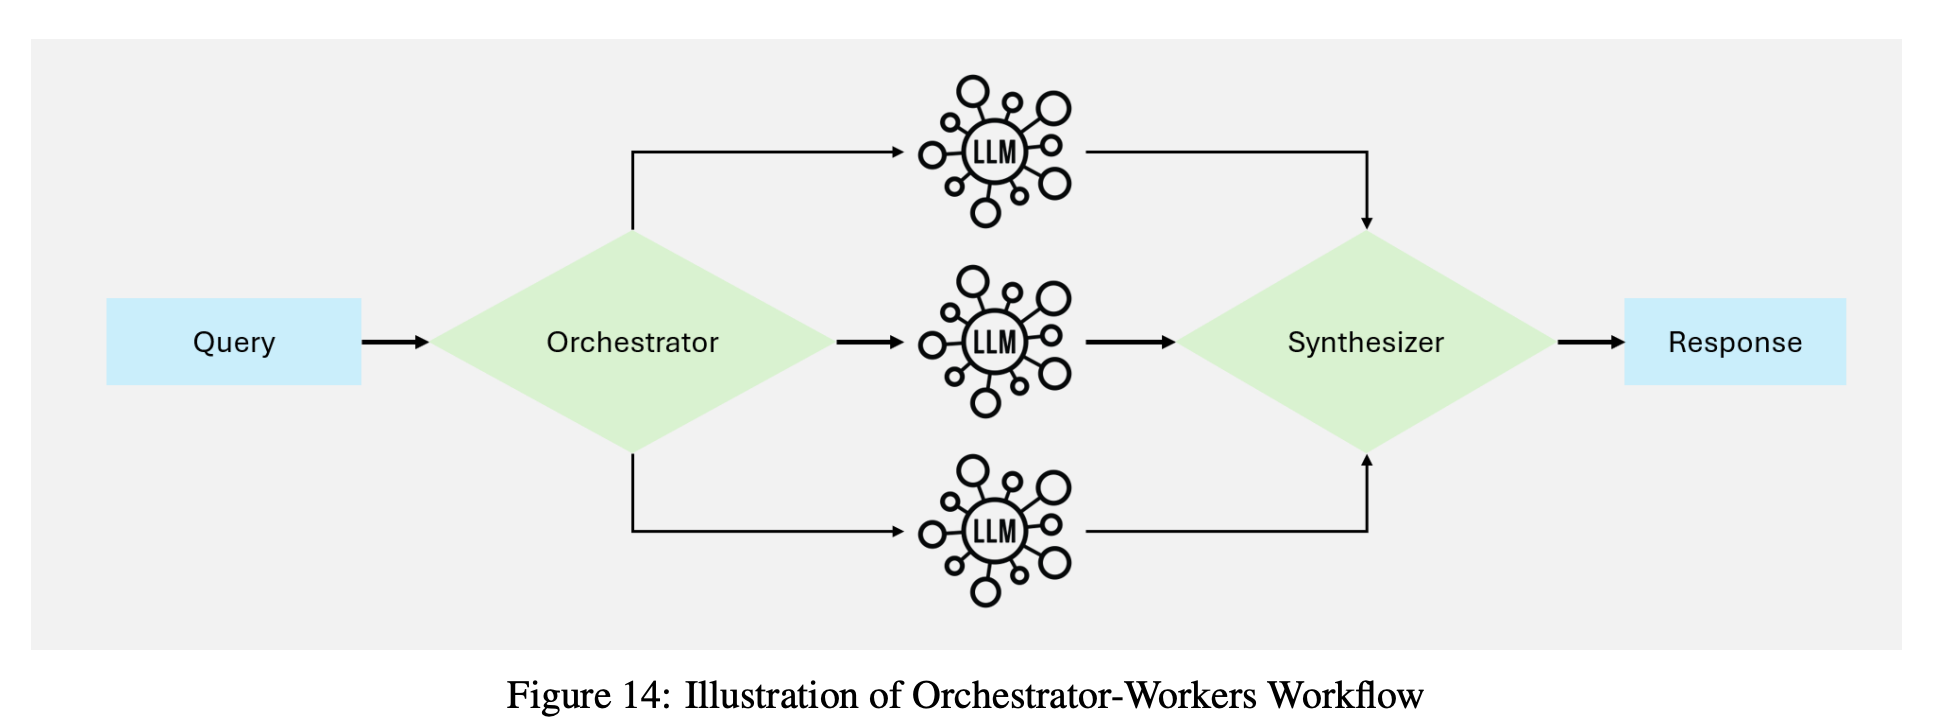


### Step 1: Setting Up Dependencies and Model

In [ ]:
from dotenv import load_dotenv
import json
from typing import List, Dict, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
import asyncio
from datetime import datetime

load_dotenv()


# Initialize the language model
travel_planner_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

travel_planner_llm.invoke("hey!")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={'usage': {'prompt_tokens': 9, 'completion_tokens': 13, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 22}, 'stop_reason': 'end_turn', 'thinking': {}, 'model_id': 'anthropic.claude-3-5-sonnet-20241022-v2:0', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, response_metadata={'usage': {'prompt_tokens': 9, 'completion_tokens': 13, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 22}, 'stop_reason': 'end_turn', 'thinking': {}, 'model_id': 'anthropic.claude-3-5-sonnet-20241022-v2:0', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='run--d69b7960-e795-46bc-8b10-6ad893e71abd-0', usage_metadata={'input_tokens': 9, 'output_tokens': 13, 'total_tokens': 22, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}})

### Step 2. Defining Task Structure with Pydantic Models

In [42]:
# Define the task structure for dynamic delegation
class TravelTask(BaseModel):
    """Structure for individual travel planning tasks"""
    task_id: str = Field(description="Unique identifier for the task")
    task_type: str = Field(description="Type of travel planning task")
    task_description: str = Field(description="Detailed description of what needs to be done")
    priority: int = Field(description="Task priority (1-5, where 5 is highest)")
    required_context: List[str] = Field(description="Context needed from original request")

class TaskPlan(BaseModel):
    """Complete task breakdown from orchestrator"""
    tasks: List[TravelTask] = Field(description="List of travel planning tasks")
    estimated_duration: str = Field(description="Estimated time to complete all tasks")
    special_requirements: List[str] = Field(description="Any special considerations")

# Create structured orchestrator
task_orchestrator = travel_planner_llm.with_structured_output(TaskPlan)


### Implementing State Reducer Functions
These reducer functions merge updates from parallel worker nodes. When multiple workers update the same fields, LangGraph uses these reducers to safely merge them.


In [58]:
# Define reducer functions for concurrent updates
def merge_worker_results(current: Dict[str, str], new: Dict[str, str]) -> Dict[str, str]:
    """Merge worker results from multiple concurrent workers"""
    if current is None:
        current = {}
    current.update(new)
    return current

def merge_execution_metadata(current: Dict[str, Any], new: Dict[str, Any]) -> Dict[str, Any]:
    """Merge execution metadata from multiple concurrent workers"""
    if current is None:
        current = {}
    
    # Merge workers_executed lists
    current_workers = current.get('workers_executed', [])
    new_workers = new.get('workers_executed', [])
    
    merged_metadata = current.copy()
    merged_metadata.update(new)
    
    # Combine worker lists without duplicates
    all_workers = list(set(current_workers + new_workers))
    merged_metadata['workers_executed'] = all_workers
    
    return merged_metadata


### Step 4: Defining the Workflow State Schema

In [59]:
# Define workflow state with proper annotations for concurrent updates
class TravelPlanningState(TypedDict):
    original_request: str                                      # User's travel request
    task_breakdown: Dict[str, Any]                            # Orchestrator's task analysis
    accommodation_result: str                                 # Accommodation worker result
    activities_result: str                                    # Activities worker result
    dining_result: str                                        # Dining worker result
    transportation_result: str                                # Transportation worker result
    worker_results: Annotated[Dict[str, str], merge_worker_results]  # Combined worker results with reducer
    final_itinerary: str                                      # Synthesized travel plan
    execution_metadata: Annotated[Dict[str, Any], merge_execution_metadata]  # Processing information with reducer


### Step 5. Building the Orchestrator Function: The Master Planner

In [60]:
def orchestrate_travel_planning(state: TravelPlanningState):
    """
    Orchestrator: Analyzes travel request and creates dynamic task breakdown
    """
    orchestrator_prompt = [
        SystemMessage(
            content="""You are a master travel planning orchestrator. Your job is to analyze 
            travel requests and break them down into specific, actionable tasks for specialist workers.
            
            Common travel planning tasks include:
            - accommodation_research: Find suitable hotels/lodging
            - activity_planning: Research attractions and experiences
            - dining_recommendations: Find restaurants and food experiences
            - transportation_planning: Plan getting around and between locations
            - budget_optimization: Ensure recommendations fit within budget
            - cultural_insights: Provide local customs and cultural information
            
            Consider the user's specific needs, timeline, budget, and preferences when creating tasks.
            Each task should be focused and actionable for a specialist worker."""
        ),
        HumanMessage(content=f"Plan travel tasks for: {state['original_request']}")
    ]
    
    # Get structured task breakdown
    task_plan = task_orchestrator.invoke(orchestrator_prompt)
    
    # Convert to dictionary for easier processing
    task_breakdown = {
        "tasks": [task.model_dump() for task in task_plan.tasks],
        "estimated_duration": task_plan.estimated_duration,
        "special_requirements": task_plan.special_requirements,
        "total_tasks": len(task_plan.tasks)
    }
    
    return {
        "task_breakdown": task_breakdown,
        "worker_results": {},  # Initialize worker results
        "execution_metadata": {
            "orchestration_timestamp": datetime.now().isoformat(),
            "task_count": len(task_plan.tasks),
            "workers_executed": []  # Track executed workers
        }
    }


### Step 6. The Workers: Specialized Experts

In [61]:
def accommodation_worker(state: TravelPlanningState):
    """Worker: Specializes in finding accommodation options"""
    original_request = state['original_request']
    
    accommodation_prompt = f"""
    You are an accommodation specialist. Based on this travel request: "{original_request}"
    
    Provide specific accommodation recommendations including:
    - Hotel/lodging names and types
    - Price ranges and booking considerations
    - Location advantages and proximity to attractions
    - Unique features or amenities
    
    Focus only on accommodation. Be specific and practical.
    """
    
    result = travel_planner_llm.invoke(accommodation_prompt)
    
    # Return updates for concurrent processing
    return {
        "accommodation_result": result.content,
        "worker_results": {"accommodation": result.content},
        "execution_metadata": {
            "workers_executed": ["accommodation_worker"]
        }
    }

def activity_worker(state: TravelPlanningState):
    """Worker: Specializes in activity and attraction planning"""
    original_request = state['original_request']
    
    activity_prompt = f"""
    You are an activities and attractions specialist. Based on this travel request: "{original_request}"
    
    Recommend specific activities, attractions, and experiences:
    - Must-see attractions and their best visiting times
    - Unique local experiences and cultural activities
    - Outdoor activities and adventure options
    - Seasonal considerations and timing
    
    Focus only on activities and attractions. Provide actionable suggestions.
    """
    
    result = travel_planner_llm.invoke(activity_prompt)
    
    # Return updates for concurrent processing
    return {
        "activities_result": result.content,
        "worker_results": {"activities": result.content},
        "execution_metadata": {
            "workers_executed": ["activity_worker"]
        }
    }

def dining_worker(state: TravelPlanningState):
    """Worker: Specializes in dining and food experiences"""
    original_request = state['original_request']
    
    dining_prompt = f"""
    You are a dining and food experience specialist. Based on this travel request: "{original_request}"
    
    Recommend dining options and food experiences:
    - Local cuisine specialties and where to find them
    - Restaurant recommendations across different price ranges
    - Food markets, street food, and casual dining
    - Unique culinary experiences and food tours
    
    Focus only on food and dining. Be specific about locations and experiences.
    """
    
    result = travel_planner_llm.invoke(dining_prompt)
    
    # Return updates for concurrent processing
    return {
        "dining_result": result.content,
        "worker_results": {"dining": result.content},
        "execution_metadata": {
            "workers_executed": ["dining_worker"]
        }
    }

def transportation_worker(state: TravelPlanningState):
    """Worker: Specializes in transportation planning"""
    original_request = state['original_request']
    
    transportation_prompt = f"""
    You are a transportation specialist. Based on this travel request: "{original_request}"
    
    Provide transportation guidance:
    - Best ways to get around the destination
    - Public transportation options and costs
    - Car rental considerations and parking
    - Airport transfers and intercity travel
    - Walking and cycling options
    
    Focus only on transportation. Provide practical, cost-effective options.
    """
    
    result = travel_planner_llm.invoke(transportation_prompt)
    
    # Return updates for concurrent processing
    return {
        "transportation_result": result.content,
        "worker_results": {"transportation": result.content},
        "execution_metadata": {
            "workers_executed": ["transportation_worker"]
        }
    }


### Step 7. The Synthesizer: Bringing It All Together

In [64]:
def synthesize_travel_plan(state: TravelPlanningState):
    """
    Synthesizer: Combines all worker outputs into a cohesive travel itinerary
    """
    worker_results = state.get('worker_results', {})
    original_request = state['original_request']
    task_info = state.get('task_breakdown', {})
    
    # Prepare synthesis prompt with all worker outputs
    synthesis_prompt = f"""
    Create a comprehensive, well-organized travel itinerary based on the original request: "{original_request}"
    
    Use the following specialist recommendations:
    
    ACCOMMODATION RECOMMENDATIONS:
    {worker_results.get('accommodation', 'Not available')}
    
    ACTIVITIES & ATTRACTIONS:
    {worker_results.get('activities', 'Not available')}
    
    DINING RECOMMENDATIONS:
    {worker_results.get('dining', 'Not available')}
    
    TRANSPORTATION GUIDANCE:
    {worker_results.get('transportation', 'Not available')}
    
    Create a cohesive, day-by-day itinerary that:
    - Logically organizes activities by location and timing
    - Integrates accommodation, dining, and transportation
    - Provides practical tips and considerations
    - Maintains a natural, engaging narrative flow
    - Includes estimated costs and time requirements
    
    Format as a complete travel guide that someone could actually follow.
    """
    
    result = travel_planner_llm.invoke(synthesis_prompt)
    
    # Return final updates
    return {
        "final_itinerary": result.content,
        "execution_metadata": {
            "synthesis_timestamp": datetime.now().isoformat(),
            "total_workers_executed": len(state.get('execution_metadata', {}).get('workers_executed', []))
        }
    }


### Step 8. The Workflow: Orchestrating the Orchestra

In [65]:
# Build the orchestrator-workers workflow
travel_workflow = StateGraph(TravelPlanningState)

# Add all nodes
travel_workflow.add_node("orchestrator", orchestrate_travel_planning)
travel_workflow.add_node("accommodation_worker", accommodation_worker)
travel_workflow.add_node("activity_worker", activity_worker)
travel_workflow.add_node("dining_worker", dining_worker)
travel_workflow.add_node("transportation_worker", transportation_worker)
travel_workflow.add_node("synthesizer", synthesize_travel_plan)

# Define workflow edges
travel_workflow.add_edge(START, "orchestrator")

# Parallel execution of workers after orchestration
travel_workflow.add_edge("orchestrator", "accommodation_worker")
travel_workflow.add_edge("orchestrator", "activity_worker")
travel_workflow.add_edge("orchestrator", "dining_worker")
travel_workflow.add_edge("orchestrator", "transportation_worker")

# All workers feed into synthesizer
travel_workflow.add_edge("accommodation_worker", "synthesizer")
travel_workflow.add_edge("activity_worker", "synthesizer")
travel_workflow.add_edge("dining_worker", "synthesizer")
travel_workflow.add_edge("transportation_worker", "synthesizer")

# Synthesizer completes the workflow
travel_workflow.add_edge("synthesizer", END)

# Compile the workflow
compiled_travel_workflow = travel_workflow.compile()

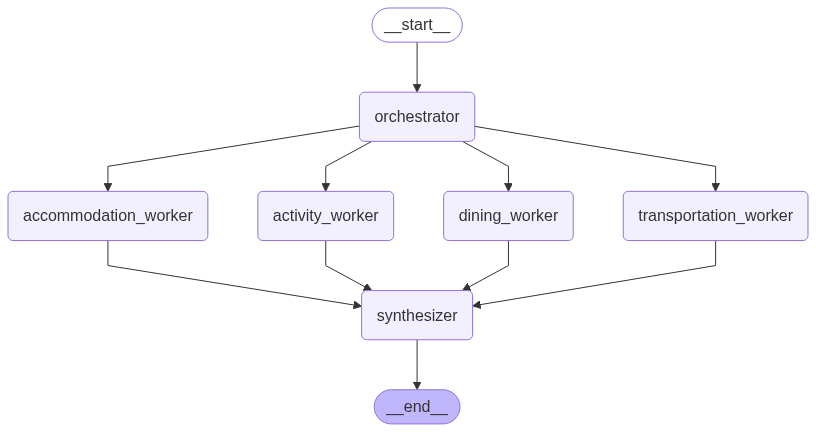

In [66]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        compiled_travel_workflow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Step 9. Testing and Validation

In [67]:
def test_travel_planner():
    """Test the orchestrator-workers travel planning system"""
    
    # Test different types of travel requests
    test_requests = [
        "Plan a 5-day romantic getaway to Paris for two people, budget $3000, interested in art and fine dining",
        "Family trip to Tokyo for 7 days, 2 adults and 2 kids (ages 8 and 12), budget $5000, love technology and culture",
        "Solo backpacking adventure in Thailand for 10 days, budget $1500, interested in temples and street food"
    ]
    
    for i, request in enumerate(test_requests, 1):
        print(f"\n{'='*60}")
        print(f"TEST {i}: {request}")
        print(f"{'='*60}")
        
        # Execute the workflow
        result = compiled_travel_workflow.invoke({
            "original_request": request
        })
        
        # Display results
        print(f"\nTask Breakdown ({result['task_breakdown']['total_tasks']} tasks):")
        for task in result['task_breakdown']['tasks']:
            print(f"  - {task['task_type']}: {task['task_description']}")
        
        # Show executed workers
        executed_workers = result['execution_metadata'].get('workers_executed', [])
        print(f"\nWorkers Executed: {', '.join(executed_workers)}")
        
        print(f"\nFinal Itinerary Preview:")
        print(result['final_itinerary'][:300] + "...")

In [68]:
# Run the test
if __name__ == "__main__":
    test_travel_planner()


TEST 1: Plan a 5-day romantic getaway to Paris for two people, budget $3000, interested in art and fine dining

Task Breakdown (6 tasks):
  - accommodation_research: Find a romantic, centrally-located hotel in Paris for 2 people for 5 nights within $1200-1500 budget range. Prioritize hotels near art districts or with easy access to major museums.
  - dining_recommendations: Research and select romantic fine dining restaurants in Paris. Include mix of Michelin-starred and intimate bistros. Reserve 2-3 special dinner experiences. Budget approximately $600-800 for fine dining experiences.
  - activity_planning: Create art-focused itinerary including Louvre, Musée d'Orsay, and other key museums. Research skip-the-line passes and optimal visiting times. Include romantic spots like evening at Eiffel Tower.
  - transportation_planning: Plan transportation from airport to hotel and research metro passes or other local transport options for 5 days. Consider romantic evening walks in itinerary 